# Training a GPT model on protein sequences (development notebook)

Compared to Shakespeare, we implement a few changes:

* We want to train the model to predict protein sequences in isolation from one another; i.e. independent of the sequences shown before.
* We want to handle the case where proteins have variables sizes, and some are shorter than the block size. To handle variable-sized proteins in batches we'll use padding with a special token and mask it later on to block the attention mechanism from/to this special token.
* We want to use PyTorch Lightning to make our life a little easier.

In [1]:
import torch
import time
import random
import numpy as np
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import matplotlib.pyplot as plt
from torch.utils.data import Sampler
from typing import Tuple

from nano_transformer import NanoTransformer


fname = "data/prot_seqs.txt"

# hyperparameters
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 32 if DEVICE == "cpu" else 64
BLOCK_SIZE = 8 if DEVICE == "cpu" else 256  # context size
N_EMBD = 16 if DEVICE == "cpu" else 384  # called d_model in paper
N_BLOCKS = 2 if DEVICE == "cpu" else 6  # number N of transformer blocks
NUM_HEADS = 2 if DEVICE == "cpu" else 6  # nr attention heads
DROPOUT = 0.2
MAX_ITERS = 5000
EVAL_INTERVAL = 500 if DEVICE == "cpu" else 10
LEARNING_RATE = 1e-3 if DEVICE == "cpu" else 3e-4
EVAL_ITERS = 200
print(f"device: {DEVICE}")

device: cpu


In [2]:
with open(fname, "r") as f:
    lines = f.readlines()

### Encoding amino acid tokens

Note: There are 24 amino acids in this dataset.
`{'U', 'X', 'O', 'Z'}` are present but not "commonly" known amino acids
See: https://en.wikipedia.org/wiki/FASTA_format for meaning.

In addition:
* `\n` means "end of protein"
* `!` is our special padding token

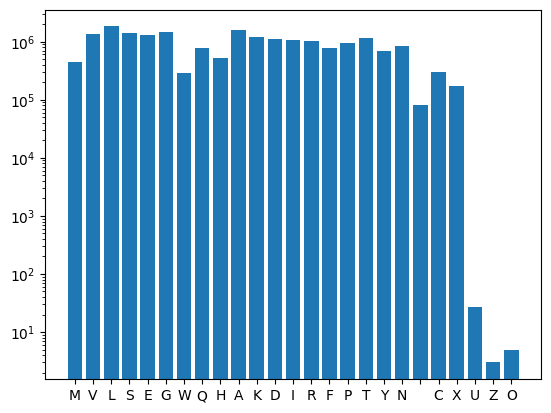

In [3]:
pad = "!"  # padding character
flat_text = [c for line in lines for c in line]  # all proteins concatenated
chars = sorted(set(flat_text)) + [pad]
vocab_size = len(chars)
stoi = {c: i for i, c in enumerate(chars)}
itos = {i: c for i, c in enumerate(chars)}

counter = Counter(flat_text)
plt.bar(counter.keys(), counter.values(), log=True);


In [4]:
def encode(s):    
    return [stoi[c] for c in s]

def decode(i):
    return "".join([itos[ii] for ii in i])

def encode_pad(s, block_size):
    encoding = encode(s)
    return encoding + [stoi[pad]] * max(0, block_size + 1 - len(encoding))



### Train / val split

In [5]:
random.seed(1337)

# There is one line per protein.
# We shuffle for train/val split (done in place).
random.shuffle(lines)

n = int(0.9 * len(lines))
train_lines = lines[:n]
val_lines = lines[n:]

## Option 1 - without PyTorch Lightning

### Data loader

Extract subsequences then pad to block size:

In [ ]:
def encode_batch(batch_lines, block_size):
    # encode with padding to block_size+1
    return [encode_pad(line, block_size) for line in batch_lines]

def get_batch(batch_size, block_size, split):
    # generate a small batch of data of inputs x and targets y
    lines_to_consider = train_lines if split == "train" else val_lines

    # ids of proteins in batch
    prot_idxs = [random.randint(0, len(lines_to_consider) - 1) for _ in range(batch_size)]
    batch_lines = [lines_to_consider[i] for i in prot_idxs]

    # encode with padding to block_size+1
    prots_encoded = encode_batch(batch_lines, block_size)

    # get random start positions for each protein; make sure we don't fetch subsequences made of padding
    start_idxs = [random.randint(0, max(0, len(batch_lines[i]) - block_size - 1))
                  for i in range(batch_size)]
    
    # build torch tensors
    x = torch.stack([torch.tensor(prots_encoded[i][start_idxs[i] : start_idxs[i] + block_size], dtype=torch.long)
                     for i in range(batch_size)])
    y = torch.stack([torch.tensor(prots_encoded[i][start_idxs[i] + 1 : start_idxs[i] + block_size + 1], dtype=torch.long) 
                     for i in range(batch_size)])
    lengths_x = torch.tensor([len(batch_lines[i]) for i in range(batch_size)], dtype=torch.long)

    x, y, lengths_x = x.to(DEVICE), y.to(DEVICE), lengths_x.to(DEVICE)
    return x, y, lengths_x

In [ ]:
random.seed(1)

x, y, l = get_batch(3, 32, "train")

print(x)
print(y)
print(l)

We need some logic to obtain a (B, T, T) mask that prevents communication between padded tokens and the other tokens:

In [ ]:
# a toy example on a small batch of size B
x_tmp = torch.tensor([[1,2,3,25,25],
                      [1,2,25,25,25]])
lengths = torch.tensor([3,2])
maxlen = x_tmp.shape[1]

mask = torch.arange(maxlen)[None, :] < lengths[:, None]
print(mask)

# mask = mask.to(torch.uint8)
# print(mask)

mask = mask[:, None, :]
mask = mask & mask.transpose(-2, -1)

weights = torch.randn(2, 5, 5)
weights = weights.masked_fill(~mask, float("-inf"))


### Build model

In [ ]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ["train", "val"]:
        losses = torch.zeros(EVAL_ITERS)
        for k in range(EVAL_ITERS):
            X, Y, Ls = get_batch(BATCH_SIZE, BLOCK_SIZE, split)
            _, loss = model(X, Y, Ls)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out


torch.manual_seed(1337)
random.seed(1337)

model = NanoTransformer(
    vocab_size=vocab_size,
    block_size=BLOCK_SIZE,
    n_embd=N_EMBD,
    n_blocks=N_BLOCKS,
    num_heads=NUM_HEADS,
    dropout=DROPOUT,
)
model = model.to(DEVICE)
print(sum(p.numel() for p in model.parameters()) / 1e6, "M parameters")

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

tic = time.time()
for iter in range(MAX_ITERS):
    # evaluate loss on train and val sets
    if iter % EVAL_INTERVAL == 0:
        losses = estimate_loss()
        print(
            f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}"
        )

    # sample a batch of data
    xb, yb, lb = get_batch(BATCH_SIZE, BLOCK_SIZE, "train")

    # evaluate the loss
    logits, loss = model(xb, yb, lb)
    optimizer.zero_grad(set_to_none=None)
    loss.backward()
    optimizer.step()
print(f"training duration: {(time.time() - tic):.2f} s.")

In order to generate, we'll use the base rates of each AA appearing in first position:

In [ ]:
nr_times_first = Counter([line[0] for line in train_lines])
aa_to_proba_first = {aa: nr_times_first[aa] / len(train_lines) for aa in nr_times_first}

plt.bar(aa_to_proba_first.keys(), aa_to_proba_first.values())
plt.xlabel("amino acid")
plt.ylabel("probability to appear in first position");

In [ ]:
# set numpy and torch seed for reproducibility
np.random.seed(1337)
torch.manual_seed(1337)

def generate_protein_string():
    # generate from the model

    # start_char_proba = {k: v / sum(counter.values()) for k, v in counter.items()}
    start_char = np.random.choice(list(aa_to_proba_first.keys()), p=list(aa_to_proba_first.values()))
    # context = torch.tensor([[stoi[start_char]]], dtype=torch.long, device=device)

    initial_context = torch.tensor([[stoi[start_char]]], dtype=torch.long, device=DEVICE)  # (1, 1)

    return decode(model.generate_line(idx=initial_context,
                                      termination_token_idx=stoi["\n"],
                                      pad_token_idx=stoi["!"],
                                      ).tolist()[:-1])  # remove the last \n

for _ in range(30):
    print(generate_protein_string())

## Option 2: with PyTorch Lightning
### Defining the Lightning Module

In [6]:
class PLNanoTransformer(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, x, y, lengths):
        return self.model(x, y, lengths)

    def training_step(self, batch, batch_idx):
        x, y, lengths = batch
        _, loss = self.model(x, y, lengths)
        self.log("train_loss", loss)
        self.logger.experiment.add_scalar("train_loss", loss, self.global_step)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y, lengths = batch
        _, loss = self.model(x, y, lengths)
        self.log("val_loss", loss)
        self.logger.experiment.add_scalar("val_loss", loss, self.global_step)
        return loss

    def configure_optimizers(self):
        return torch.optim.AdamW(self.model.parameters(), lr=LEARNING_RATE)
    

torch.manual_seed(1337)
random.seed(1337)

inner_model = NanoTransformer(
    vocab_size=vocab_size,
    block_size=BLOCK_SIZE,
    n_embd=N_EMBD,
    n_blocks=N_BLOCKS,
    num_heads=NUM_HEADS,
    dropout=DROPOUT,
)
# inner_model = inner_model.to(DEVICE)

nano_prot_gpt = PLNanoTransformer(inner_model)

### Defining a Dataset and DataLoader

We need to define a custome PyTorch `Dataset` which disambiguates between line indices and subsequence start indices.

In [7]:
class LineDataset(Dataset):
    def __init__(self, lines):
        self.lines = sorted(lines, key=len, reverse=True)
        nr_samples_per_line = [len(line) - BLOCK_SIZE for line in self.lines]
        self.num_samples = sum(nr_samples_per_line)
        self.line_idx_to_cumulative_nr_samples = np.array([0] + np.cumsum(nr_samples_per_line).tolist())

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # infer line idx from idx, using binary search over line_idx_to_cumulative_nr_samples
        # np.searchsorted() returns the index of the first element in the array that is greater than the value
        line_idx = np.searchsorted(self.line_idx_to_cumulative_nr_samples, idx, side="right") - 1
        start_idx = idx - self.line_idx_to_cumulative_nr_samples[line_idx]

        line = self.lines[line_idx]
        line_encoded = encode_pad(line, BLOCK_SIZE)

        x = torch.tensor(line_encoded[start_idx : start_idx + BLOCK_SIZE], dtype=torch.long)
        y = torch.tensor(line_encoded[start_idx + 1 : start_idx + BLOCK_SIZE + 1], dtype=torch.long)
        length = torch.tensor(min(len(line), BLOCK_SIZE), dtype=torch.long)
        return x, y, length
    
# sampler = SubsequenceSampler(train_lines)
train_dataset = LineDataset(train_lines)
train_loader = DataLoader(dataset=train_dataset,
                    batch_size=BATCH_SIZE,
                    shuffle=True)

val_dataset = LineDataset(val_lines)
val_loader = DataLoader(dataset=val_dataset,
                    batch_size=BATCH_SIZE,
                    shuffle=False)

### Training the model

In [8]:
from pytorch_lightning.callbacks import TQDMProgressBar
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning import seed_everything

seed_everything(1337)

logger = TensorBoardLogger("tensorboard_logs", name="nano_prot_gpt")

# log hyperparameters
logger.log_hyperparams({
    "block_size": BLOCK_SIZE,
    "n_embd": N_EMBD,
    "n_blocks": N_BLOCKS,
    "num_heads": NUM_HEADS,
    "dropout": DROPOUT,
    "max_iters": MAX_ITERS,
    "learning_rate": LEARNING_RATE,
    "batch_size": BATCH_SIZE,
})

trainer = pl.Trainer(max_steps=MAX_ITERS,
                     val_check_interval=EVAL_INTERVAL,
                     limit_val_batches=200,  # only run eval on 0.5% of the validation set
                     callbacks=[TQDMProgressBar(refresh_rate=20)],
                     precision=32,
                     logger=logger,
                     accelerator=DEVICE)

trainer.fit(model=nano_prot_gpt, 
            train_dataloaders=train_loader, 
            val_dataloaders=val_loader)

Global seed set to 1337
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/julien/miniconda3/envs/prot-gpt/lib/python3.10/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(

  | Name  | Type            | Params
------------------------------------------
0 | model | NanoTransformer | 7.5 K 
------------------------------------------
7.5 K     Trainable params
0         Non-trainable params
7.5 K     Total params
0.030     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/julien/miniconda3/envs/prot-gpt/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/julien/miniconda3/envs/prot-gpt/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
%load_ext tensorboard

TODO:
* Proper management of accelerators
* Early stopping
* `auto_lr_find`
* Maybe `auto_scale_batch_size`
* Maybe `gradient_clip_val`